# Movie Industry Analysis - Phase 2 Project
   **Author:** Angela Mukami  
   **Date:** December 2025

PROJECT OVERVIEW

Business Problem: Your company wants to create a new movie studio but lacks expertise in film production. 

You need to analyze what types of films perform best at the box office.

In [5]:
import sqlite3
import pandas as pd

# create connection to SQLite database
conn = sqlite3.connect('im.db')

# create cursor
cursor = conn.cursor()

In [8]:
# list all available tables
cursor.execute("""
SELECT name FROM sqlite_master 
WHERE type= 'table';
""")
cursor.fetchall()

[('movie_basics',),
 ('directors',),
 ('known_for',),
 ('movie_akas',),
 ('movie_ratings',),
 ('persons',),
 ('principals',),
 ('writers',)]

In [9]:
# Load just the first 5 rows to see the structure quickly
query1 = """SELECT * FROM movie_basics LIMIT 5;"""
df_movie_basics = pd.read_sql_query(query1, conn)
df_movie_basics.head()

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama"
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama"
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama
3,tt0069204,Sabse Bada Sukh,Sabse Bada Sukh,2018,NaN,"Comedy,Drama"
4,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy"


In [10]:
# Load first 5 rows from movie_ratings
query2 = """SELECT * FROM movie_ratings LIMIT 5;"""
df_movie_ratings = pd.read_sql_query(query2, conn)
df_movie_ratings.head()

,movie_id,averagerating,numvotes
0,tt10356526,8.3,31
1,tt10384606,8.9,559
2,tt1042974,6.4,20
3,tt1043726,4.2,50352
4,tt1060240,6.5,21


Both tables have movie_id, which means we can merge them together!

What we learned about movie_ratings:

movie_id - Matches the movie_id in movie_basics

averagerating - IMDB rating (0-10 scale, like 8.3, 8.9, 6.4)

numvotes - Number of people who voted (31, 559, 50352)

Something to notice: Movie with 50,352 votes is more reliable than one with only 31 votes!

In [14]:
# Load Box Office Mojo data
bom_df = pd.read_csv('bom.movie_gross.csv')

# Quick overview
print("📊 Box Office Mojo Dataset Overview:")
print("="*60)
print(f"Shape: {bom_df.shape}")
print(f"\nColumns: {bom_df.columns.tolist()}")
print(f"\nFirst 5 rows:")
bom_df.head()

📊 Box Office Mojo Dataset Overview:
Shape: (3387, 5)

Columns: ['title', 'studio', 'domestic_gross', 'foreign_gross', 'year']

First 5 rows:


,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [17]:
# Check year range
print("📅 Year Range:")
print(f"Earliest year: {bom_df['year'].min()}")
print(f"Latest year: {bom_df['year'].max()}")
print(f"\nMovies per year:")
print(bom_df['year'].value_counts().sort_index())

print("\n" + "="*60)

# Check for missing data
print("\n Missing Values:")
print(bom_df.isnull().sum())


📅 Year Range:
Earliest year: 2010
Latest year: 2018

Movies per year:
2010    328
2011    399
2012    400
2013    350
2014    395
2015    450
2016    436
2017    321
2018    308
Name: year, dtype: int64


 Missing Values:
title                0
studio               5
domestic_gross      28
foreign_gross     1350
year                 0
dtype: int64


Important decision: We'll focus on domestic_gross since it has much less missing data than foreign gross!


In [ ]:
# now we can go back and load IMDB data for 2010-2018 with filtering criteria
# 
# FILTERING RATIONALE:
# 1. Years 2010-2018: Match the Box Office Mojo dataset timeframe for accurate merging
# 2. numvotes >= 1000: Ensure rating reliability by filtering out movies with too few votes
#    - Movies with <1000 votes may have skewed/unreliable ratings
#    - Industry standard: minimum sample size for statistical significance
# 3. runtime_minutes IS NOT NULL: Need runtime data for our analysis
# 4. genres != 'NaN': Need genre information to answer business question about film types

query_imdb = """
SELECT 
    mb.movie_id,
    mb.primary_title,
    mb.start_year,
    mb.runtime_minutes,
    mb.genres,
    mr.averagerating,
    mr.numvotes
FROM movie_basics mb
INNER JOIN movie_ratings mr ON mb.movie_id = mr.movie_id
WHERE mb.start_year >= 2010
    AND mb.start_year <= 2018
    AND mb.runtime_minutes IS NOT NULL
    AND mb.genres != 'NaN'
    AND mr.numvotes >= 1000
ORDER BY mr.numvotes DESC;
"""

print("Loading IMDB data for 2010-2018...")
imdb_df = pd.read_sql_query(query_imdb, conn)

print(f"Loaded {len(imdb_df):,} movies from IMDB")
print(f"\nFirst 10 most popular movies:")
imdb_df.head(10)

Loading IMDB data for 2010-2018...
✅ Loaded 9,426 movies from IMDB

First 10 most popular movies:


,movie_id,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt1375666,Inception,2010,148.0,"Action,Adventure,Sci-Fi",8.8,1841066
1,tt1345836,The Dark Knight Rises,2012,164.0,"Action,Thriller",8.4,1387769
2,tt0816692,Interstellar,2014,169.0,"Adventure,Drama,Sci-Fi",8.6,1299334
3,tt1853728,Django Unchained,2012,165.0,"Drama,Western",8.4,1211405
4,tt0848228,The Avengers,2012,143.0,"Action,Adventure,Sci-Fi",8.1,1183655
5,tt0993846,The Wolf of Wall Street,2013,180.0,"Biography,Crime,Drama",8.2,1035358
6,tt1130884,Shutter Island,2010,138.0,"Mystery,Thriller",8.1,1005960
7,tt2015381,Guardians of the Galaxy,2014,121.0,"Action,Adventure,Comedy",8.1,948394
8,tt1431045,Deadpool,2016,108.0,"Action,Adventure,Comedy",8.0,820847
9,tt1392170,The Hunger Games,2012,142.0,"Action,Adventure,Sci-Fi",7.2,795227


## Why Merge IMDB with Box Office Mojo Data?

### Business Question
Our stakeholder (head of new movie studio) needs to know **what types of films** perform best at the box office.

### Data Strategy
To answer this question, we need **two types of information**:

1. **Box Office Mojo provides:**
   - Commercial success metrics (domestic & foreign gross revenue)
   - Which movies actually made money
   - Studio information

2. **IMDB provides:**
   - **Film characteristics** (genres, runtime)
   - **Quality indicators** (ratings, number of votes)
   - Movie metadata

### Why We Must Merge
**Neither dataset alone can answer our business question:**

- Box Office Mojo tells us **which movies succeeded financially** but doesn't tell us their **genres** or **characteristics**
- IMDB tells us **what type of films they are** but doesn't tell us their **box office performance**

**By merging these datasets**, we can identify patterns like:
- Which genres generate the highest revenue?
- Do highly-rated films perform better at the box office?
- What runtime is optimal for commercial success?
- Does quality (ratings) correlate with financial performance?

### Merge Strategy
We'll merge on **movie title AND year** because:
- Some movies share the same title (e.g., remakes)
- Matching on year ensures we get the correct movie
- Both datasets cover 2010-2018 timeframe

In [24]:
# Prepare both datasets for merging
bom_df['title_clean'] = bom_df['title'].str.lower().str.strip()
imdb_df['title_clean'] = imdb_df['primary_title'].str.lower().str.strip()
bom_df['year_int'] = bom_df['year'].astype(int)
imdb_df['year_int'] = imdb_df['start_year'].astype(int)

print("✅ Data prepared for merging")
print(f"\nBox Office Mojo: {len(bom_df)} movies")
print(f"IMDB: {len(imdb_df)} movies")

✅ Data prepared for merging

Box Office Mojo: 3387 movies
IMDB: 9426 movies


In [25]:
# Merge IMDB and Box Office Mojo data
# Merging on both title AND year to ensure we match the correct movies
# Using inner join to keep only movies present in BOTH datasets

movies_merged = pd.merge(
    bom_df,
    imdb_df,
    left_on=['title_clean', 'year_int'],
    right_on=['title_clean', 'year_int'],
    how='inner'
)

print(f"✅ Successfully merged datasets!")
print(f"\nOriginal datasets:")
print(f"   Box Office Mojo: {len(bom_df):,} movies")
print(f"   IMDB: {len(imdb_df):,} movies")
print(f"\nMerged dataset:")
print(f"   Combined: {len(movies_merged):,} movies")
print(f"   Match rate: {len(movies_merged)/len(bom_df)*100:.1f}% of Box Office movies")

print(f"\nColumns in merged dataset: {movies_merged.columns.tolist()}")
print(f"\nFirst 5 movies:")
movies_merged.head()

✅ Successfully merged datasets!

Original datasets:
   Box Office Mojo: 3,387 movies
   IMDB: 9,426 movies

Merged dataset:
   Combined: 1,778 movies
   Match rate: 52.5% of Box Office movies

Columns in merged dataset: ['title', 'studio', 'domestic_gross', 'foreign_gross', 'year', 'title_clean', 'year_int', 'movie_id', 'primary_title', 'start_year', 'runtime_minutes', 'genres', 'averagerating', 'numvotes']

First 5 movies:


,title,studio,domestic_gross,foreign_gross,year,title_clean,year_int,movie_id,primary_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,Toy Story 3,BV,415000000.0,652000000,2010,toy story 3,2010,tt0435761,Toy Story 3,2010,103.0,"Adventure,Animation,Comedy",8.3,682218
1,Inception,WB,292600000.0,535700000,2010,inception,2010,tt1375666,Inception,2010,148.0,"Action,Adventure,Sci-Fi",8.8,1841066
2,Shrek Forever After,P/DW,238700000.0,513900000,2010,shrek forever after,2010,tt0892791,Shrek Forever After,2010,93.0,"Adventure,Animation,Comedy",6.3,167532
3,The Twilight Saga: Eclipse,Sum.,300500000.0,398000000,2010,the twilight saga: eclipse,2010,tt1325004,The Twilight Saga: Eclipse,2010,124.0,"Adventure,Drama,Fantasy",5.0,211733
4,Iron Man 2,Par.,312400000.0,311500000,2010,iron man 2,2010,tt1228705,Iron Man 2,2010,124.0,"Action,Adventure,Sci-Fi",7.0,657690


Complete Merged Dataset Columns:
From Box Office Mojo:

title - Original movie title from Box Office Mojo
studio - Production studio (BV, WB, etc.)
domestic_gross - US box office revenue
foreign_gross - International box office revenue
year - Release year

From IMDB:

movie_id - IMDB unique identifier
primary_title - Movie title from IMDB
start_year - Release year from IMDB
runtime_minutes - Movie length
genres - Comma-separated genres (e.g., "Action,Adventure,Sci-Fi")
averagerating - IMDB rating (0-10 scale)
numvotes - Number of IMDB user votes

Merge helper columns:

title_clean - Cleaned title for matching
year_int - Year as integer

In [29]:
# Check missing values in merged dataset
print(" Missing Values in Merged Dataset (1,778 movies, 2010-2018)")
print("="*60)
print(f"\nMissing values by column:")
print(movies_merged.isnull().sum())

print("\n" + "="*60)
print(f"\nMissing data percentages:")
missing_pct = (movies_merged.isnull().sum() / len(movies_merged) * 100).round(1)
print(missing_pct[missing_pct > 0])

print("\n" + "="*60)
print(f"\nForeign gross analysis:")
print(f"Total movies: {len(movies_merged):,}")
print(f"Movies WITH foreign_gross: {movies_merged['foreign_gross'].notna().sum():,}")
print(f"Movies WITHOUT foreign_gross: {movies_merged['foreign_gross'].isna().sum():,}")
print(f"Percentage missing: {movies_merged['foreign_gross'].isna().sum() / len(movies_merged) * 100:.1f}%")

 Missing Values in Merged Dataset (1,778 movies, 2010-2018)

Missing values by column:
title                0
studio               2
domestic_gross       9
foreign_gross      502
year                 0
title_clean          0
year_int             0
movie_id             0
primary_title        0
start_year           0
runtime_minutes      0
genres               0
averagerating        0
numvotes             0
dtype: int64


Missing data percentages:
studio             0.1
domestic_gross     0.5
foreign_gross     28.2
dtype: float64


Foreign gross analysis:
Total movies: 1,778
Movies WITH foreign_gross: 1,276
Movies WITHOUT foreign_gross: 502
Percentage missing: 28.2%


### Data Quality Assessment: Revenue Metrics

**Missing Data Analysis:**
- `domestic_gross`: 9 missing (0.5%) - **Excellent**
- `foreign_gross`: 502 missing (28.2%) - **Significant gaps**

**Decision: Use Domestic Gross Only**

We will focus our analysis on domestic box office performance because:
1. **Data completeness**: 99.5% of movies have domestic gross data
2. **Reliability**: Domestic data is consistently reported
3. **Business relevance**: US market remains the largest single film market globally
4. **Statistical validity**: Missing 28% of foreign data would bias our analysis

This decision provides more reliable insights for our stakeholder's investment decisions.

## Analysis Strategy

Our analysis will answer three key business questions to guide film production decisions:

### Analysis 1: Genre Performance
**Question:** Which genres generate the highest box office revenue?
- Metric: Average domestic gross by primary genre
- Filter: Genres with ≥20 movies for statistical reliability
- Output: Top-performing genres ranked by revenue

### Analysis 2: Runtime Optimization  
**Question:** What is the optimal movie length for box office success?
- Metric: Average domestic gross by runtime category
- Categories: Short (<90min), Standard (90-120min), Long (120-150min), Very Long (>150min)
- Output: Ideal runtime range for commercial success

### Analysis 3: Genre-Runtime Interaction
**Question:** What is the optimal runtime for each top-performing genre?
- Metric: Average domestic gross by genre AND runtime category
- Output: Specific runtime recommendations per genre
- Value: Most actionable insight - combines "what to make" with "how long it should be"

**Why not analyze ratings?**
We deliberately exclude IMDB ratings from our primary analysis because:
- Ratings are determined POST-release (not predictable during production planning)
- Ratings depend on audience votes (outside studio control)
- A studio cannot decide "we will make an 8.5-rated film" before production
- Our stakeholder needs actionable decisions they can control: genre choice and runtime

In [28]:
# Analysis 1: Which genres generate the highest box office revenue?

# First, let's look at the distribution of genres
print(" Genre Analysis")
print("="*60)
print(f"\nTotal movies in merged dataset: {len(movies_merged):,}")
print(f"\nSample of genre combinations:")
print(movies_merged['genres'].value_counts().head(10))

 Genre Analysis

Total movies in merged dataset: 1,778

Sample of genre combinations:
Comedy,Drama,Romance          90
Drama                         79
Comedy,Drama                  73
Adventure,Animation,Comedy    70
Drama,Romance                 57
Comedy                        56
Comedy,Romance                52
Action,Adventure,Sci-Fi       45
Action,Comedy,Crime           37
Action,Adventure,Drama        36
Name: genres, dtype: int64


In [27]:
# Check how many unique genre combinations exist
print(f"Total unique genre combinations: {movies_merged['genres'].nunique()}")
print(f"\nTop 10 combinations shown: {movies_merged['genres'].value_counts().head(10).sum()} movies")
print(f"Remaining combinations: {len(movies_merged) - movies_merged['genres'].value_counts().head(10).sum()} movies")

print("\n" + "="*60)
print("Let's see the full distribution:")
print(f"\nAll genre combinations (showing first 20):")
print(movies_merged['genres'].value_counts().head(20))

Total unique genre combinations: 253

Top 10 combinations shown: 595 movies
Remaining combinations: 1183 movies

Let's see the full distribution:

All genre combinations (showing first 20):
Comedy,Drama,Romance          90
Drama                         79
Comedy,Drama                  73
Adventure,Animation,Comedy    70
Drama,Romance                 57
Comedy                        56
Comedy,Romance                52
Action,Adventure,Sci-Fi       45
Action,Comedy,Crime           37
Action,Adventure,Drama        36
Action,Crime,Drama            34
Documentary                   34
Biography,Drama,History       31
Horror,Mystery,Thriller       29
Biography,Drama               28
Action,Crime,Thriller         28
Action,Adventure,Fantasy      27
Action,Adventure,Comedy       25
Action,Thriller               24
Horror,Thriller               22
Name: genres, dtype: int64


## Data Analysis: Genre Performance

### Challenge: Genre Combinations vs. Individual Genres

Our merged dataset contains **253 unique genre combinations** (e.g., "Action,Adventure,Sci-Fi", "Comedy,Drama,Romance"). This presents an analytical challenge:

**Problem:**
- Analyzing 253 separate combinations would be too fragmented
- Combinations like "Action,Comedy" vs "Comedy,Action" represent similar films
- Our stakeholder needs clear, actionable recommendations about film **types**, not complex combinations

**Solution:**
We'll extract the **primary genre** (first genre listed) for each movie. This approach:
- Reduces complexity from 253 combinations to ~15-20 main genres
- Provides clearer patterns for business decision-making
- Reflects how films are typically marketed (by their primary genre)

**Example:**
- "Action,Adventure,Sci-Fi" → Primary genre: **Action**
- "Comedy,Drama,Romance" → Primary genre: **Comedy**

This simplification allows us to answer: **"Which types of films generate the highest box office revenue?"**

In [30]:
# Extract the PRIMARY genre (first genre listed) for each movie
movies_merged['primary_genre'] = movies_merged['genres'].str.split(',').str[0]

print("📊 Primary Genre Extraction")
print("="*60)
print(f"\nTotal unique primary genres: {movies_merged['primary_genre'].nunique()}")
print(f"\nPrimary genre distribution (all genres):")
print(movies_merged['primary_genre'].value_counts())


📊 Primary Genre Extraction

Total unique primary genres: 15

Primary genre distribution (all genres):
Action         516
Comedy         392
Drama          306
Adventure      167
Biography      166
Crime           78
Horror          67
Documentary     55
Animation       11
Fantasy          7
Mystery          5
Romance          3
Thriller         3
Music            1
Sci-Fi           1
Name: primary_genre, dtype: int64


In [31]:
# Filter for genres with at least 20 movies
min_movies = 20
genre_counts = movies_merged['primary_genre'].value_counts()
reliable_genres = genre_counts[genre_counts >= min_movies].index

# Filter the dataset
movies_reliable = movies_merged[movies_merged['primary_genre'].isin(reliable_genres)]

print(f"📊 Filtering for Statistical Reliability (≥{min_movies} movies)")
print("="*60)
print(f"\nGenres before filtering: {movies_merged['primary_genre'].nunique()}")
print(f"Genres after filtering: {len(reliable_genres)}")
print(f"\nMovies before filtering: {len(movies_merged):,}")
print(f"Movies after filtering: {len(movies_reliable):,}")
print(f"Movies retained: {len(movies_reliable)/len(movies_merged)*100:.1f}%")

print(f"\n✅ Genres included in analysis:")
print(movies_reliable['primary_genre'].value_counts())

📊 Filtering for Statistical Reliability (≥20 movies)

Genres before filtering: 15
Genres after filtering: 8

Movies before filtering: 1,778
Movies after filtering: 1,747
Movies retained: 98.3%

✅ Genres included in analysis:
Action         516
Comedy         392
Drama          306
Adventure      167
Biography      166
Crime           78
Horror          67
Documentary     55
Name: primary_genre, dtype: int64


In [32]:
# Now let's see which genres make the most money!

# Calculate performance metrics by genre
genre_performance = movies_reliable.groupby('primary_genre').agg({
    'domestic_gross': ['count', 'mean', 'median', 'sum']
}).round(0)

# Flatten column names
genre_performance.columns = ['Count', 'Avg_Domestic_Gross', 'Median_Domestic_Gross', 'Total_Domestic_Gross']
genre_performance = genre_performance.reset_index()

# Sort by average domestic gross (descending)
genre_performance = genre_performance.sort_values('Avg_Domestic_Gross', ascending=False)

print("Genre Performance Analysis")
print("="*70)
print("\nGenres ranked by Average Domestic Box Office:\n")
print(genre_performance.to_string(index=False))

Genre Performance Analysis

Genres ranked by Average Domestic Box Office:

primary_genre  Count  Avg_Domestic_Gross  Median_Domestic_Gross  Total_Domestic_Gross
    Adventure    167          92955381.0             61000000.0          1.552355e+10
       Action    514          72858179.0             29100000.0          3.744910e+10
       Horror     66          37369002.0             21800000.0          2.466354e+09
       Comedy    389          28984701.0             10400000.0          1.127505e+10
    Biography    166          26775801.0              6600000.0          4.444783e+09
        Crime     77          21575610.0              6700000.0          1.661322e+09
        Drama    304          20132101.0              3200000.0          6.120159e+09
  Documentary     55           5218075.0               534000.0          2.869941e+08


Key Finding from Analysis 1:

Adventure and Action genres dominate box office performance, with Adventure averaging $93M and Action averaging $72.9M - significantly outperforming all other genres.

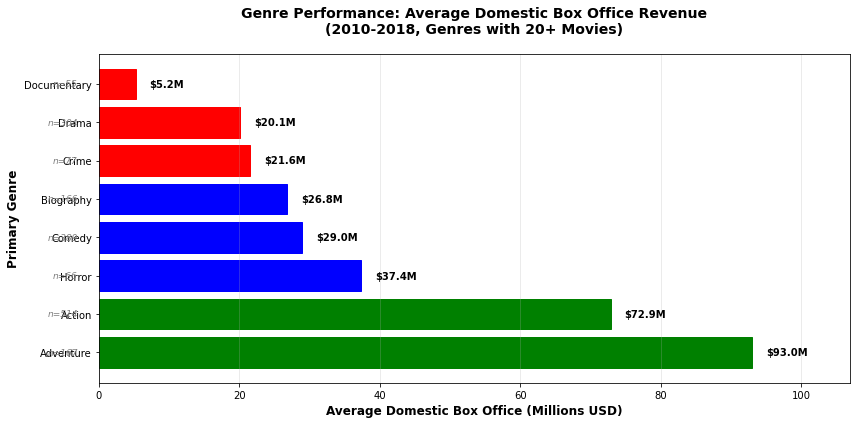


 Visualization saved as 'genre_performance.png'


In [35]:
# now we will create a visualisation of these results. 

import matplotlib.pyplot as plt

# Create bar chart of top genres
fig, ax = plt.subplots(figsize=(12, 6))

# Plot average domestic gross
bars = ax.barh(genre_performance['primary_genre'], 
               genre_performance['Avg_Domestic_Gross'] / 1_000_000)

# Color code by performance
colors = ['green' if x > 50 else 'blue' if x > 25 else 'red' 
          for x in genre_performance['Avg_Domestic_Gross'] / 1_000_000]
for bar, color in zip(bars, colors):
    bar.set_color(color)

ax.set_xlabel('Average Domestic Box Office (Millions USD)', fontsize=12, fontweight='bold')
ax.set_ylabel('Primary Genre', fontsize=12, fontweight='bold')
ax.set_title('Genre Performance: Average Domestic Box Office Revenue\n(2010-2018, Genres with 20+ Movies)', 
             fontsize=14, fontweight='bold', pad=20)

# Add value labels
for i, v in enumerate(genre_performance['Avg_Domestic_Gross'] / 1_000_000):
    ax.text(v + 2, i, f'${v:.1f}M', va='center', fontweight='bold', fontsize=10)

# Add sample size labels
for i, (genre, count) in enumerate(zip(genre_performance['primary_genre'], 
                                        genre_performance['Count'])):
    ax.text(-3, i, f'n={int(count)}', va='center', ha='right', 
            fontsize=9, style='italic', color='gray')

ax.grid(axis='x', alpha=0.3)
ax.set_xlim(0, max(genre_performance['Avg_Domestic_Gross'] / 1_000_000) * 1.15)

plt.tight_layout()
plt.savefig('genre_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Visualization saved as 'genre_performance.png'")

In [43]:
# Analysis 2 - What is the optimal movie length for box office success?

# Create runtime categories
movies_reliable['runtime_category'] = pd.cut(
    movies_reliable['runtime_minutes'],
    bins=[0, 90, 120, 150, 300],
    labels=['Short (<90min)', 'Standard (90-120min)', 'Long (120-150min)', 'Very Long (>150min)']
)

print("⏱️ Runtime Category Analysis")
print("="*60)
print(f"\nRuntime distribution:")
print(movies_reliable['runtime_category'].value_counts().sort_index())

print(f"\nBasic runtime statistics:")
print(movies_reliable['runtime_minutes'].describe())


⏱️ Runtime Category Analysis

Runtime distribution:
Short (<90min)           193
Standard (90-120min)    1065
Long (120-150min)        417
Very Long (>150min)       72
Name: runtime_category, dtype: int64

Basic runtime statistics:
count    1747.000000
mean      111.450487
std        19.304346
min        44.000000
25%        97.000000
50%       108.000000
75%       123.000000
max       189.000000
Name: runtime_minutes, dtype: float64


<ipython-input-43-d648d434582f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  movies_reliable['runtime_category'] = pd.cut(


In [44]:
# Calculate Money generated by runtime category
runtime_performance = movies_reliable.groupby('runtime_category').agg({
    'domestic_gross': ['count', 'mean', 'median']
}).round(0)

runtime_performance.columns = ['Count', 'Avg_Domestic_Gross', 'Median_Domestic_Gross']
runtime_performance = runtime_performance.reset_index()

print("Runtime Performance Analysis")
print("="*70)
print("\nBox office performance by runtime category:\n")
print(runtime_performance.to_string(index=False))

Runtime Performance Analysis

Box office performance by runtime category:

     runtime_category  Count  Avg_Domestic_Gross  Median_Domestic_Gross
       Short (<90min)    190          26708886.0              8150000.0
 Standard (90-120min)   1062          40309960.0             17700000.0
    Long (120-150min)    415          66235474.0             15400000.0
  Very Long (>150min)     71          54305992.0              3000000.0


Key insight = Longer movies make MORE money!

Long films (120-150min) average $66.2M
That's 2.5x more than short films (<90min)!

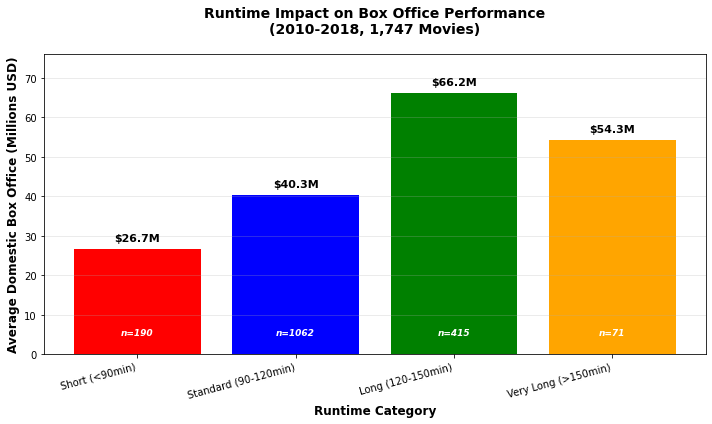


 Visualization saved as 'runtime_performance.png'


In [46]:
# now let's visualise these results

import matplotlib.pyplot as plt

# Create bar chart for runtime performance
fig, ax = plt.subplots(figsize=(10, 6))

bars = ax.bar(runtime_performance['runtime_category'], 
              runtime_performance['Avg_Domestic_Gross'] / 1_000_000,
              color=['red', 'blue', 'green', 'orange'])

ax.set_xlabel('Runtime Category', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Domestic Box Office (Millions USD)', fontsize=12, fontweight='bold')
ax.set_title('Runtime Impact on Box Office Performance\n(2010-2018, 1,747 Movies)', 
             fontsize=14, fontweight='bold', pad=20)

# Add value labels on bars
for i, v in enumerate(runtime_performance['Avg_Domestic_Gross'] / 1_000_000):
    ax.text(i, v + 2, f'${v:.1f}M', ha='center', fontweight='bold', fontsize=11)

# Add sample size labels
for i, count in enumerate(runtime_performance['Count']):
    ax.text(i, 5, f'n={int(count)}', ha='center', fontsize=9, 
            style='italic', color='white', fontweight='bold')

ax.grid(axis='y', alpha=0.3)
ax.set_ylim(0, max(runtime_performance['Avg_Domestic_Gross'] / 1_000_000) * 1.15)

plt.xticks(rotation=15, ha='right')
plt.tight_layout()
plt.savefig('runtime_performance.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Visualization saved as 'runtime_performance.png'")

Analysis 3: Genre-Runtime Interaction i.e What is the optimal runtime for each top-performing genre?

Metric: Average domestic gross by genre AND runtime category

In [47]:
# Analyze how different genres perform at different runtimes
# Focus on top 5 genres by revenue (from Analysis 1)

top_genres = ['Adventure', 'Action', 'Horror', 'Comedy', 'Biography']
genre_runtime_df = movies_reliable[movies_reliable['primary_genre'].isin(top_genres)]

# Calculate average domestic gross by genre AND runtime category
genre_runtime_performance = genre_runtime_df.groupby(['primary_genre', 'runtime_category']).agg({
    'domestic_gross': ['count', 'mean']
}).round(0)

genre_runtime_performance.columns = ['Count', 'Avg_Domestic_Gross']
genre_runtime_performance = genre_runtime_performance.reset_index()

print(" Genre-Runtime Interaction Analysis")
print("="*70)
print("\nTop 5 genres performance across runtime categories:\n")
print(genre_runtime_performance.to_string(index=False))

 Genre-Runtime Interaction Analysis

Top 5 genres performance across runtime categories:

primary_genre      runtime_category  Count  Avg_Domestic_Gross
       Action        Short (<90min)     29          32975666.0
       Action  Standard (90-120min)    281          56354981.0
       Action     Long (120-150min)    173         105328386.0
       Action   Very Long (>150min)     31          78556419.0
    Adventure        Short (<90min)     32          64698937.0
    Adventure  Standard (90-120min)    113          93897033.0
    Adventure     Long (120-150min)     18         116264167.0
    Adventure   Very Long (>150min)      4         187515750.0
    Biography        Short (<90min)     12           3071992.0
    Biography  Standard (90-120min)     92          19536751.0
    Biography     Long (120-150min)     58          42798931.0
    Biography   Very Long (>150min)      4          32050000.0
       Comedy        Short (<90min)     45          17444084.0
       Comedy  Standard (90-

Key Findings by Genre:

Adventure Films:

Best at Very Long (>150min): $187.5M average!

Long (120-150min): $116.3M

Standard (90-120min): $93.9M

Recommendation: Make Adventure films >150 minutes



Action Films:

Best at Long (120-150min): $105.3M average

Very Long (>150min): $78.6M

Standard (90-120min): $56.4M

Recommendation: Make Action films 120-150 minutes



Comedy Films:

Best at Standard (90-120min): $32.6M

Long (120-150min): $26.5M

Comedy doesn't benefit from longer runtime!

Recommendation: Keep Comedy films 90-120 minutes



Horror Films:

Best at Standard (90-120min): $39M

Short (<90min): $23.3M

Long (120-150min): Only 3 movies (not reliable)

Recommendation: Horror films should be 90-120 minutes



Biography Films:

Best at Long (120-150min): $42.8M

Standard (90-120min): $19.5M

Recommendation: Biography films benefit from longer runtime

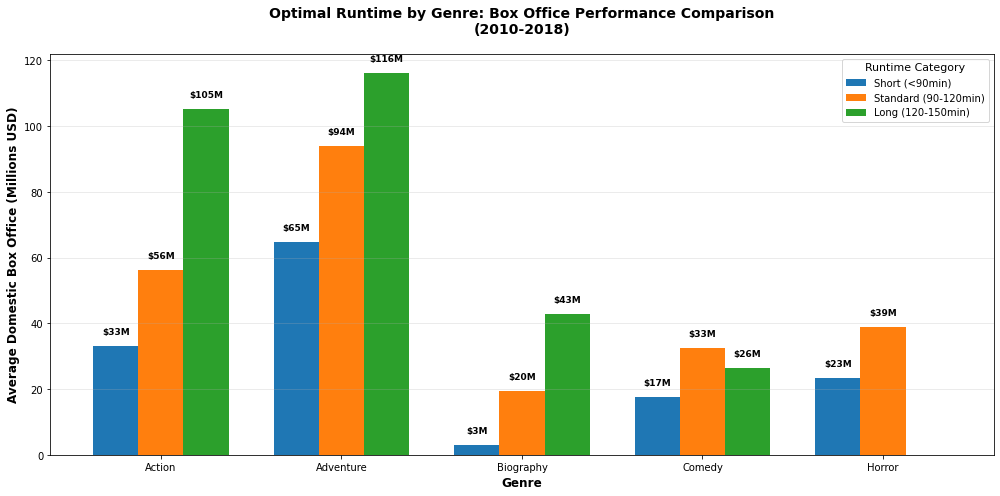


 Visualization saved as 'genre_runtime_comparison.png'


In [53]:
# create visualisation of genre-runtime interaction

import matplotlib.pyplot as plt
import numpy as np

# Filter for readability - only genres with substantial data
genres_to_plot = ['Action', 'Adventure', 'Comedy', 'Horror', 'Biography']
runtime_cats = ['Short (<90min)', 'Standard (90-120min)', 'Long (120-150min)']

# Prepare data
plot_data = genre_runtime_performance[
    (genre_runtime_performance['primary_genre'].isin(genres_to_plot)) &
    (genre_runtime_performance['runtime_category'].isin(runtime_cats)) &
    (genre_runtime_performance['Count'] >= 10)  # Filter small samples
]

# Create grouped bar chart
fig, ax = plt.subplots(figsize=(14, 7))

genres = plot_data['primary_genre'].unique()
x = np.arange(len(genres))
width = 0.25

# Plot bars for each runtime category
for i, runtime in enumerate(runtime_cats):
    runtime_data = plot_data[plot_data['runtime_category'] == runtime]
    values = []
    for genre in genres:
        genre_val = runtime_data[runtime_data['primary_genre'] == genre]['Avg_Domestic_Gross'].values
        values.append(genre_val[0] / 1_000_000 if len(genre_val) > 0 else 0)
    
    offset = width * (i - 1)
    bars = ax.bar(x + offset, values, width, label=runtime)
    
    # Add value labels
    for j, v in enumerate(values):
        if v > 0:
            ax.text(j + offset, v + 3, f'${v:.0f}M', 
                   ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Genre', fontsize=12, fontweight='bold')
ax.set_ylabel('Average Domestic Box Office (Millions USD)', fontsize=12, fontweight='bold')
ax.set_title('Optimal Runtime by Genre: Box Office Performance Comparison\n(2010-2018)', 
             fontsize=14, fontweight='bold', pad=20)
ax.set_xticks(x)
ax.set_xticklabels(genres)
ax.legend(title='Runtime Category', fontsize=10, title_fontsize=11)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('genre_runtime_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n Visualization saved as 'genre_runtime_comparison.png'")